In [2]:
import csv
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

#### Read the file
Skipping irrelevant data: death date not within the expected year and pages created after the beginning of the year (to filter out the bias of posthumous pages creation)

In [3]:
def read_file(year):
    d = []
    filename = "deaths{}.csv".format(year)
    with open(filename, 'r') as f:
        r = csv.reader(f)
        for row in r:
            if row[0]=='Name': continue
            name = row[0]
            birth = date.fromisoformat(row[1])
            death = date.fromisoformat(row[2])
            covid = (row[3] == 'True')
            created = date.fromisoformat(row[4])
            if death < date(year,1,1) or death >=date(year+1,1,1):
                print ("Page {} weird death date {}".format(name, death))
                continue
            if created >= date(year,1,1):
                #print ("Page {} created too late: {}".format(name, death))
                continue
            d.append([name,birth,death,covid,created])
    return d

In [4]:
d2020 = read_file(2020)

Page Iryna Bekeshkina weird death date 2010-03-20
Page Charles Stuart Bowyer weird death date 1985-05-31
Page Glenn Steil Sr. weird death date 2010-05-07
Page Murad Wilfried Hofmann weird death date 2019-12-20
Page Stanislav Libenský and Jaroslava Brychtová weird death date 2002-02-24
Page Del Martin and Phyllis Lyon weird death date 2008-08-27
Page John J. Myers weird death date 2016-11-07
Page Étienne Périer (director) weird death date 2010-06-21
Page Kiing Shooter weird death date 2019-12-20


In [5]:
def hist_death(data, start_day, end_day=None, filt=None):
    if not filt: filt = lambda _: True
    if not end_day: end_day = date(start_day.year+1,1,1)
    num_days = (end_day-start_day).days
    dates = [start_day+timedelta(days=j) for j in range(num_days)]
    count = np.zeros(num_days)
    for row in data:
        if not filt(row):
            continue
        j=(row[2]-start_day).days
        if j<0 or j>=num_days:
            continue
        count[j]+=1
    return dates, count

In [6]:
end_day = max(row[2] for row in d2020) + timedelta(days=1)
start_day = date(2020,1,1)
dates2020, count_all = hist_death(d2020, start_day, end_day)
_, count_cvd = hist_death(d2020, start_day, end_day, lambda row: row[3])
_, count_base = hist_death(d2020, start_day, end_day, lambda row: not row[3])

In [7]:
def ma(x, win=7):
    w = np.ones(win)/win
    return np.convolve(x, w, 'valid')
ma_all = ma(count_all)
ma_cvd = ma(count_cvd)
ma_base = ma(count_base)

In [8]:
d2019 = read_file(2019)

Page Bettina F. Bradbury weird death date 2006-01-20
Page Steve Cash weird death date 2020-10-13
Page Hein & Oss weird death date 2016-02-14
Page Susan Irvine weird death date 2013-08-05
Page Sushil Kumar (admiral) weird death date 2001-12-29
Page Ehsan-ul-Haq Piracha weird death date 1990-12-06
Page Keith Robbins weird death date 2001-08-31
Page Augie and Margo Rodriguez weird death date 2014-07-18
Page Hogan Sheffer weird death date 2006-08-09
Page Jan Paul Strid weird death date 2018-12-25
Page Sam Szafran weird death date 2011-01-30
Page Brian Tarantina weird death date 1980-03-30
Page Marv Terhoch weird death date 1981-05-31
Page Ed and Lorraine Warren weird death date 2006-08-23


In [9]:
dates2019, count2019 = hist_death(d2019, date(2019,1,1))
ma2019 = ma(count2019)

#### Plotting daily mortality
`All` - all deaths; `COVID` - deaths with COVID or coronavirus mentioned; `Base` - non-COVID deaths; 2019 - corresponding data from 2019 for comparison.
The solid lines are 7 day moving average.

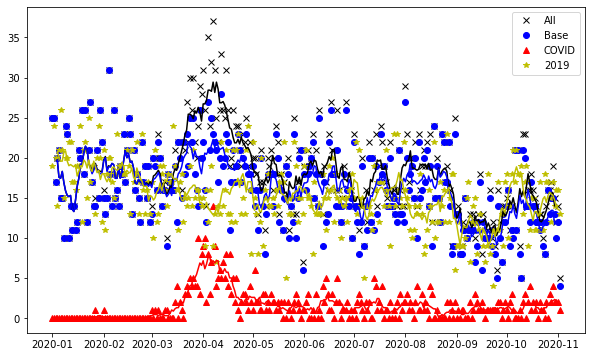

In [12]:
plt.figure(figsize=(10,6))
plt.plot_date(dates2020, count_all, 'kx')
plt.plot_date(dates2020, count_base, 'bo')
plt.plot_date(dates2020, count_cvd, 'r^')
plt.plot_date(dates2020, count2019[:len(dates2020)], 'y*')
plt.plot_date(dates2020[3:-3], ma_all, 'k-')
plt.plot_date(dates2020[3:-3], ma_base, 'b-')
plt.plot_date(dates2020[3:-3], ma_cvd, 'r-')
plt.plot_date(dates2020[3:], ma2019[:len(dates2020)-3], 'y-')
plt.legend(['All', 'Base', 'COVID', '2019'])

In [13]:
np.sum(count_all)

5475.0

In [14]:
np.sum(count_cvd)/np.sum(count_all)

0.08621004566210046

In [15]:
ages = [(row[2] - row[1])/timedelta(days=365.25) for row in d2020]
ages_cvd = [(row[2] - row[1])/timedelta(days=365.25) for row in d2020 if row[3]]

#### Age at death histogram
Blue = all deaths; orange = COVID deaths

(array([ 0.,  0.,  1.,  0.,  1.,  2.,  3.,  3., 10.,  4.,  7., 24., 36.,
        34., 65., 69., 76., 63., 49., 18.,  6.,  1.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
        110.]),
 <a list of 22 Patch objects>)

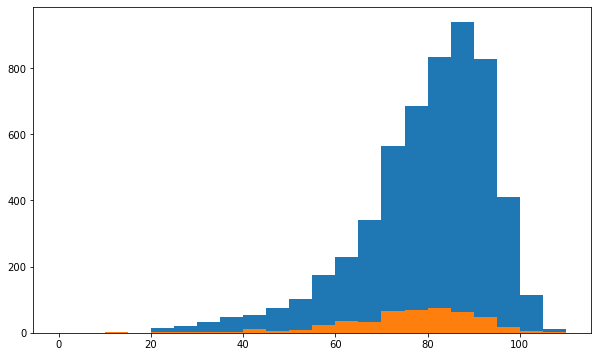

In [16]:
plt.figure(figsize=(10,6))
plt.hist(ages, bins=22, range=(0,110))
plt.hist(ages_cvd, bins=22, range=(0,110))

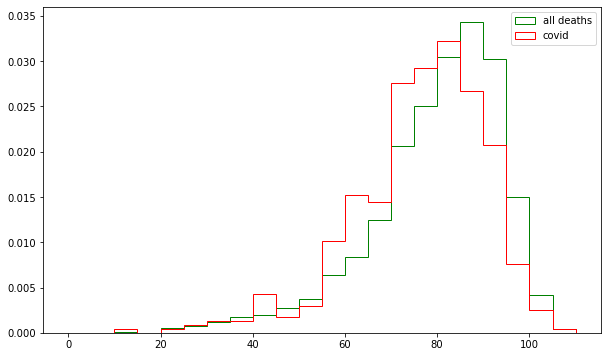

In [17]:
plt.figure(figsize=(10,6))
plt.hist(ages, bins=22, histtype='step', color='g', density=1, range=(0,110))
plt.hist(ages_cvd, bins=22, histtype='step', color='r', density=1, range=(0,110))
plt.legend(['all deaths', 'covid'])

In [18]:
np.median(ages), np.median(ages_cvd), np.average(ages), np.average(ages_cvd)

(82.60369609856262, 78.24777549623545, 79.76985601280164, 76.44834046798688)

### Cumulative anomaly comparing to the 2017-2019 average since start of the year

In [19]:
d2018 = read_file(2018)
dates2018, count2018 = hist_death(d2018, date(2018,1,1))
d2017 = read_file(2017)
dates2017, count2017 = hist_death(d2017, date(2017,1,1))

Page Dugan Aguilar weird death date 2008-01-27
Page Maxine Asher weird death date 2015-03-19
Page Rahim Uddin Bharosha weird death date 2020-03-11
Page Scotty Bloch weird death date 2013-01-10
Page Pearl Carr & Teddy Johnson weird death date 2020-02-16
Page Edoardo Catellani weird death date 2019-07-10
Page Valentin Chaikin weird death date 1955-01-10
Page John Conboy weird death date 2004-03-15
Page Rodolfo de la Garza weird death date 2019-08-05
Page Christa Dichgans weird death date 1997-02-26
Page Marianne Eigenheer weird death date 2012-02-11
Page Caroline Hebbe weird death date 1959-01-18
Page Billy Ray Irick weird death date 1985-04-16
Page Hans Joachim Keil III weird death date 2019-08-31
Page Oleg Lobov weird death date 1991-11-15
Page Margo McCaffery weird death date 2008-01-09
Page Özden Örnek weird death date 2005-08-26
Page César Paredes Canto weird death date 2016-07-05
Page Alice and Martin Provensen weird death date 1987-03-27
Page Robert Roripaugh weird death date 2019

In [20]:
c2020 = np.cumsum(count_all)
c2019 = np.cumsum(count2019)
c2018 = np.cumsum(count2018)
c2017 = np.cumsum(count2017)
print(c2017[-1], c2018[-1], c2019[-1], c2020[-1])

5392.0 5505.0 5648.0 5475.0


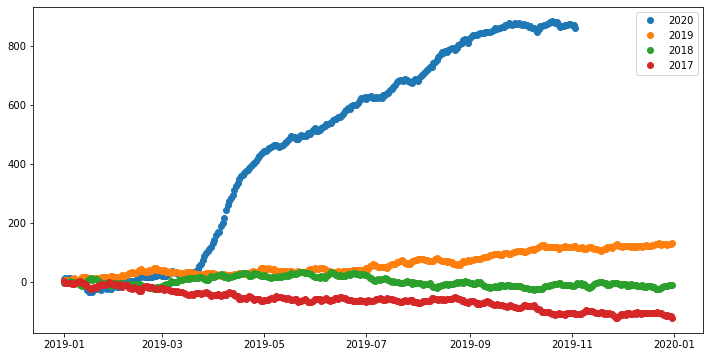

In [21]:
plt.figure(figsize=(12,6))
cavg = (c2019+c2018+c2017)/3.0
plt.plot_date(dates2019[:len(c2020)], c2020-cavg[:len(c2020)])
plt.plot_date(dates2019, c2019-cavg)
plt.plot_date(dates2019, c2018-cavg)
plt.plot_date(dates2019, c2017-cavg)
plt.legend(['2020', '2019', '2018', '2017'])

#### Same but trying to control against the corpus size

In [22]:
wp_size = np.array([5321200, 5541900, 5773600, 5989400])
weight = wp_size[-1]/wp_size
print(weight)
cs2017, cs2018, cs2019, cs2020 = c2017*weight[0], c2018*weight[1], c2019*weight[2], c2020*weight[3]

[1.12557318 1.08074848 1.03737703 1.        ]


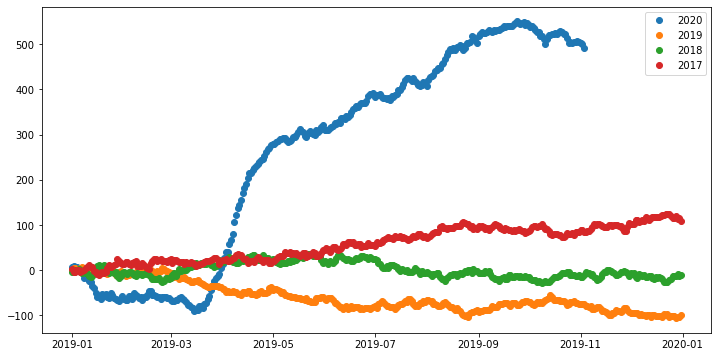

In [23]:
plt.figure(figsize=(12,6))
csavg = (cs2019+cs2018+cs2017)/3.0
plt.plot_date(dates2019[:len(c2020)], cs2020-csavg[:len(c2020)])
plt.plot_date(dates2019, cs2019-csavg)
plt.plot_date(dates2019, cs2018-csavg)
plt.plot_date(dates2019, cs2017-csavg)
plt.legend(['2020', '2019', '2018', '2017'])

Doesn't look very good, probably the corpus growth for people is slower. Ok, let's assume there was a linear corpus growth (at scale of 10% linear doesn't significantly differ from exponential).

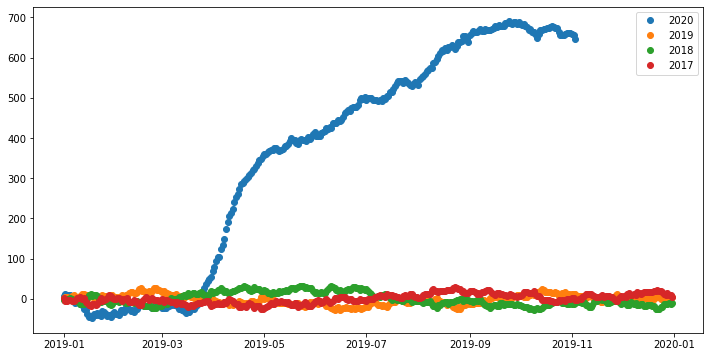

In [24]:
f1,f0 = np.polyfit([2017,2018,2019], [c2017[-1],c2018[-1],c2019[-1]], deg=1)
eoy = f0+f1*np.array([2017,2018,2019,2020])
yearly = (c2019+c2018+c2017)/3.0 - eoy[1]*np.arange(365)/365
plt.figure(figsize=(12,6))
plt.plot_date(dates2019[:len(c2020)], c2020-eoy[3]*np.arange(len(c2020))/365-yearly[:len(c2020)])
plt.plot_date(dates2019, c2019-eoy[2]*np.arange(365)/365-yearly)
plt.plot_date(dates2019, c2018-eoy[1]*np.arange(365)/365-yearly)
plt.plot_date(dates2019, c2017-eoy[0]*np.arange(365)/365-yearly)
plt.legend(['2020','2019','2018','2017'])

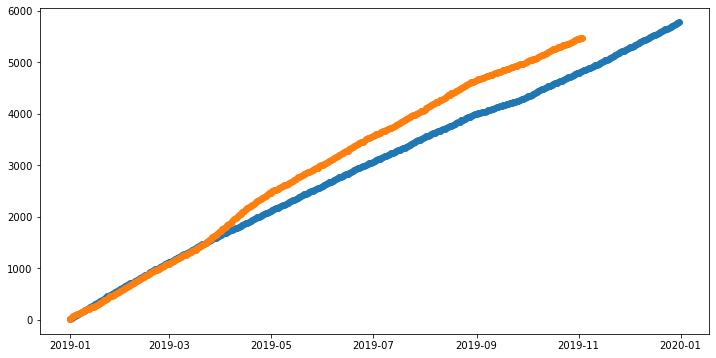

In [25]:
expected = (c2019+c2018+c2017)/3.0 + 2*f1*np.arange(365)/365
plt.figure(figsize=(12,6))
plt.plot_date(dates2019,expected)
plt.plot_date(dates2019[:len(c2020)], c2020)

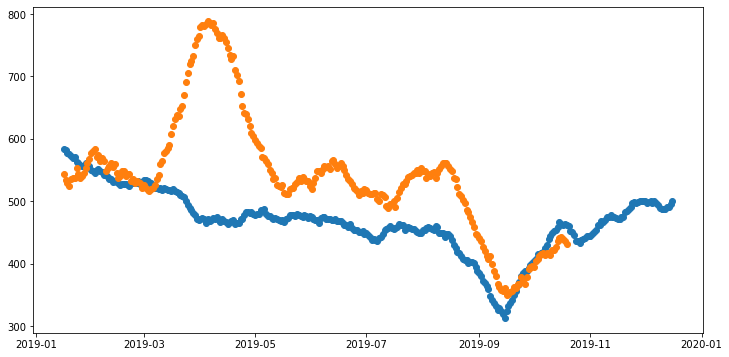

In [26]:
WINDOW=30
plt.figure(figsize=(12,6))
plt.plot_date(dates2019[WINDOW//2:-WINDOW//2], expected[WINDOW:]-expected[:-WINDOW])
plt.plot_date(dates2019[WINDOW//2:len(c2020)-WINDOW//2], c2020[WINDOW:]-c2020[:-WINDOW])

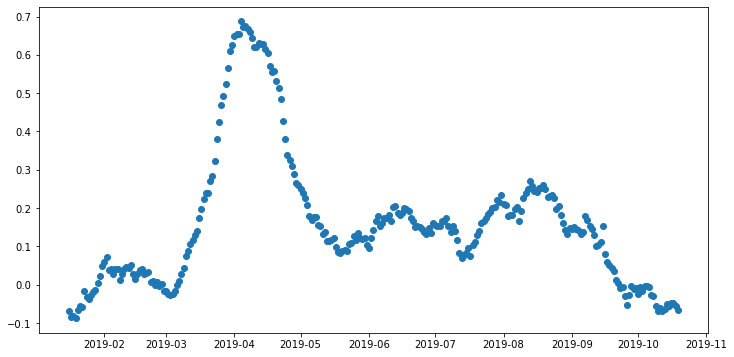

In [27]:
excess=(c2020[WINDOW:]-c2020[:-WINDOW])/(expected[WINDOW:len(c2020)]-expected[:len(c2020)-WINDOW])-1
plt.figure(figsize=(12,6))
plt.plot_date(dates2019[WINDOW//2:len(c2020)-WINDOW//2], excess)